In [1]:
# !pip3 install torch torchvision torchaudio
# !pip install h5py

In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)
torch.manual_seed(0)

def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    trainX = np.array(train_dataset["train_set_x"][:])  # (209, 64, 64, 3)
    trainY = np.array(train_dataset["train_set_y"][:])  # (209,)
    
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    testX = np.array(test_dataset["test_set_x"][:])      # (50, 64, 64, 3)
    testY = np.array(test_dataset["test_set_y"][:])        # (50,)
    
    classes = np.array(test_dataset["list_classes"][:])
    
    # reshape labels to (n,1)
    trainY = trainY.reshape(-1, 1)
    testY = testY.reshape(-1, 1)
    
    return trainX, trainY, testX, testY, classes

# Load and preprocess data
original_trainX, original_trainY, original_testX, original_testY, classes = load_data()

# Flatten each image: (num_samples, 64*64*3) and normalize to [0,1]
trainX = original_trainX.reshape(original_trainX.shape[0], -1) / 255.0
testX = original_testX.reshape(original_testX.shape[0], -1) / 255.0

# Convert numpy arrays to PyTorch tensors
trainX = torch.tensor(trainX, dtype=torch.float32)
trainY = torch.tensor(original_trainY, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
testY = torch.tensor(original_testY, dtype=torch.float32)

# Define the network: dimensions [12288, 20, 7, 5, 1]
model = nn.Sequential(
    nn.Linear(12288, 20),
    nn.ReLU(),
    nn.Linear(20, 7),
    nn.ReLU(),
    nn.Linear(7, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()  # outputs probability between 0 and 1
)

# Initialize weights with Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)

# Loss and optimizer
criterion = nn.BCELoss()  # binary cross entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [2]:
num_epochs = 2000
costs = []
train_acc = []
valid_acc = []

from time import time

a = time()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(trainX)  # shape: (209, 1)
    loss = criterion(outputs, trainY)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record cost
    costs.append(loss.item())
    
    # Compute training accuracy
    preds = (outputs > 0.5).float()
    acc = (preds.eq(trainY).sum().item()) / trainY.size(0)
    train_acc.append(acc)
    
    # Compute validation accuracy
    with torch.no_grad():
        test_outputs = model(testX)
        test_preds = (test_outputs > 0.5).float()
        vacc = (test_preds.eq(testY).sum().item()) / testY.size(0)
        valid_acc.append(vacc)
    
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}, Train Acc {acc:.4f}, Valid Acc {vacc:.4f}")

b = time()
print(f'---\ntime taken: {b-a:.4f} s')

Epoch 0: Loss 0.8799, Train Acc 0.3445, Valid Acc 0.6600
Epoch 100: Loss 0.6370, Train Acc 0.8278, Valid Acc 0.5000
Epoch 200: Loss 0.5749, Train Acc 0.8517, Valid Acc 0.5400
Epoch 300: Loss 0.5626, Train Acc 0.8278, Valid Acc 0.5800
Epoch 400: Loss 0.4376, Train Acc 0.9378, Valid Acc 0.5400
Epoch 500: Loss 0.3749, Train Acc 0.9474, Valid Acc 0.5800
Epoch 600: Loss 0.3209, Train Acc 0.9522, Valid Acc 0.6400
Epoch 700: Loss 0.2984, Train Acc 0.9569, Valid Acc 0.6200
Epoch 800: Loss 0.2394, Train Acc 0.9809, Valid Acc 0.6600
Epoch 900: Loss 0.2077, Train Acc 0.9856, Valid Acc 0.6400
Epoch 1000: Loss 0.2083, Train Acc 0.9856, Valid Acc 0.6400
Epoch 1100: Loss 0.1656, Train Acc 0.9904, Valid Acc 0.6600
Epoch 1200: Loss 0.1501, Train Acc 0.9904, Valid Acc 0.7000
Epoch 1300: Loss 0.1355, Train Acc 0.9904, Valid Acc 0.7400
Epoch 1400: Loss 0.1247, Train Acc 0.9952, Valid Acc 0.7400
Epoch 1500: Loss 0.1207, Train Acc 0.9904, Valid Acc 0.7400
Epoch 1600: Loss 0.1065, Train Acc 0.9952, Valid Acc

In [3]:
%matplotlib inline

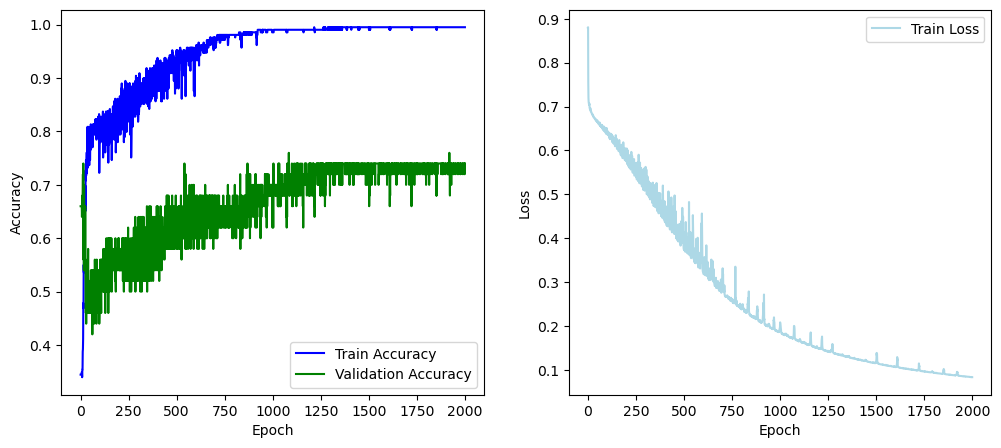

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(valid_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(costs, label='Train Loss', color='lightblue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()